In [1]:
### Emma Beyer & Desa Bolger
### emma.beyer@duke.edu & desa.bolger@duke.edu

#The goal of this document is to explore the relation of wrecks in NC and presence of military bases

#Read in packages
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

In [2]:
#Read Wrecks in NC EEZ into a Pandas dataframe
NC_Wrecks = gpd.read_file('../Data/Processed/ONLYncWRECKS.shp')
NC_Wrecks.head()

,Join_Count,TARGET_FID,FID_Wrecks,positionqu,objectname,objectcate,yearsunk,comment,datasource,sourcereco,...,NEAR_DIST,UIDENT,DEPTH,RANGE,EDIT,EDIT_DATE,Shape_Le_1,Shape__Are,Shape__Len,geometry
0,1,1,0,Low,HERCULES,wreck,0.0,"00470 01 DATED 1923 24 NO.8824 - SCHOONER, 163...",AWOIS,AWOIS,...,0.0,12109,3,501-2500 metres in depth,NEW,20060000,1.116557e+08,4.352814e+12,1.116557e+08,POINT (-79.5831 30.71691)
1,1,2,0,Low,ESSO GETTYSBURG,wreck,0.0,"00478 24 NO.1162 - TANKER, 10172 GT - SUNK 6/1...",AWOIS,AWOIS,...,0.0,12109,3,501-2500 metres in depth,NEW,20060000,1.116557e+08,4.352814e+12,1.116557e+08,POINT (-79.24976 31.00024)
2,1,3,0,Low,DAISY FORLIN,wreck,0.0,"00479 01 1920 24 NO.8804 - 466 GT, SUNK 11/18/...",AWOIS,AWOIS,...,0.0,289909,1,0-200 metres in depth,NEW,20060000,3.649745e+08,6.383595e+12,3.649745e+08,POINT (-80.16646 31.00024)
3,1,4,0,None,None,wreck,0.0,None,US4GA11M.000,ENCAWPT,...,0.0,289909,1,0-200 metres in depth,NEW,20060000,3.649745e+08,6.383595e+12,3.649745e+08,POINT (-80.96661 31.31684)
4,1,5,0,Low,None,wreck,0.0,"NM41/47(5360) WK OF A TUG, WILL BE MARKED WITH...",AWOIS,AWOIS,...,0.0,289909,1,0-200 metres in depth,NEW,20060000,3.649745e+08,6.383595e+12,3.649745e+08,POINT (-80.96648 31.3169)


In [3]:
#Read Miliary Bases into a Pandas dataframe
US_Bases = gpd.read_file('../Data/Raw/tl_2024_us_mil.shp')
US_Bases.head()

,AREAID,FULLNAME,MTFCC,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,110509768024,Tripler Army Medical Ctr,K2110,1443458,0,+21.3620086,-157.8896492,"POLYGON ((-157.89816 21.3603, -157.89811 21.36..."
1,110509767829,Makua Mil Res,K2110,17406401,0,+21.5307680,-158.2068764,"POLYGON ((-158.24063 21.54513, -158.24056 21.5..."
2,110435324283,Stone Ranch Mil Res,K2110,7440946,0,+41.3654109,-72.2716641,"MULTIPOLYGON (((-72.26356 41.35362, -72.26342 ..."
3,110507841923,Ng Havre de Grace Mil Res,K2110,304109,0,+39.5327115,-76.1041621,"POLYGON ((-76.11008 39.53547, -76.10854 39.536..."
4,110509768183,Aliamanu Mil Res,K2110,2104132,0,+21.3609483,-157.9117716,"POLYGON ((-157.92377 21.35844, -157.92362 21.3..."


In [4]:
#Check coordinate systems
NC_Wrecks.crs == US_Bases.crs

False

In [5]:
#Change US_Bases to fit Wreck data
print("Current CRS:", US_Bases.crs)
US_Bases = US_Bases.to_crs("EPSG:4326")
print("Current CRS:", US_Bases.crs) 

#Recheck coordinate systems
print(NC_Wrecks.crs == US_Bases.crs)

Current CRS: EPSG:4269
Current CRS: EPSG:4326
True


AxesSubplot(0.28786,0.11;0.449279x0.77)


C:\Users\ekb41\AppData\Local\Temp\ipykernel_9396\2921294085.py:11: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  NC_CoastalBases.to_file("../Data/Processed/NC_CoastalBases.shp")
C:\Users\ekb41\AppData\Local\ESRI\conda\envs\gis\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


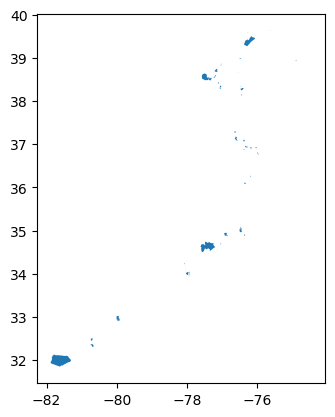

In [6]:
#Read in NC counties into a Pandas dataframe
NC_Waters = gpd.read_file('../Data/Processed/NCeezwithin200.shp')

#Subset US Bases to only include the ones that touch NC Federal Waters
NC_CoastalBases = gpd.sjoin(US_Bases, NC_Waters, how='inner', predicate='intersects')

#Check new subset
print(NC_CoastalBases.plot())

#Save new NC Coastal Bases shapefile
NC_CoastalBases.to_file("../Data/Processed/NC_CoastalBases.shp")

<AxesSubplot: >

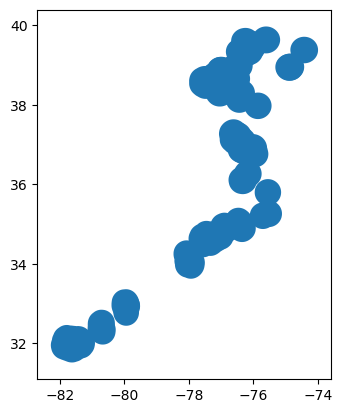

In [7]:
#Create a 20 nm buffer of the Miliary Bases

#Reproject NC_CoastalBases GeoDataFrame to a projected CRS (UTM zone 17N (EPSG:32617) for North Carolina)
NC_CoastalBases_projected = NC_CoastalBases.to_crs(epsg=32617)

#Create a 20 nm (92600 m) buffer around the military bases in the projected CRS
NC_Bases_buffer_projected = NC_CoastalBases_projected.buffer(37040)  

#Convert the buffer back to the original CRS 
NC_Bases_buffer_gdf = gpd.GeoDataFrame(geometry=NC_Bases_buffer_projected, crs=NC_CoastalBases_projected.crs)
NC_Bases_buffer_gdf = NC_Bases_buffer_gdf.to_crs(NC_CoastalBases.crs)  

#Plot the results
NC_Bases_buffer_gdf.plot()

In [8]:
#Subset NC Wrecks to only include the ones that are within the 50 nm buffer
WrecksWithinBuffer = gpd.sjoin(NC_Wrecks, NC_Bases_buffer_gdf, how='inner', predicate='within')

#Check counts of wrecks
print(f"There were {len(WrecksWithinBuffer)} wrecks within 20 nm of North Carolina Mililary Bases.")
print(f"There were {len(NC_Wrecks)} wrecks within the entire North Carolina Federal Waters.")

#Note that the new buffered points included duplicates and needs to be updates

There were 9035 wrecks within 20 nm of North Carolina Mililary Bases.
There were 3464 wrecks within the entire North Carolina Federal Waters.


In [9]:
#Remove the duplicated points
Unique_WrecksWithinBuffer = WrecksWithinBuffer.drop_duplicates(subset='geometry')

#Check the counts of wrecks again
print(f"There were {len(Unique_WrecksWithinBuffer)} wrecks within 20 nm of North Carolina Military Bases.")
print(f"There were {len(NC_Wrecks)} wrecks within the entire North Carolina Federal Waters.")
print(f"That means that {(len(Unique_WrecksWithinBuffer)) / (len(NC_Wrecks)) * 100}% of wrecks happened within 20 nm of a military base.")

There were 2559 wrecks within 20 nm of North Carolina Military Bases.
There were 3464 wrecks within the entire North Carolina Federal Waters.
That means that 73.87413394919169% of wrecks happened within 20 nm of a military base.


In [10]:
#Read in NC Federal Waters into a Pandas dataframe
NC_EEZ = gpd.read_file('../Data/Processed/NCBuffer.shp')

#Plot of Federal Waters
ax = NC_EEZ.plot(color='lightblue', edgecolor='black', figsize=(10, 10))

#Plot of All wrecks within federal waters
NC_Wrecks.plot(ax=ax, color='lightgrey', edgecolor='black', markersize=20)

#Plot of Wrecks within 20 nm of military bases
Unique_WrecksWithinBuffer.plot(ax=ax, color='red', edgecolor='black', markersize=20)

#Plot of Military Bases
NC_CoastalBases.plot(ax=ax, color='yellow', edgecolor='black')
plt.title('Wrecks within 20 nm of NC Mililary Bases')

#Create custom legend
handles = [
    plt.Line2D([0], [0], marker='o', color='lightblue', label='Study Area', markersize=10),
    plt.Line2D([0], [0], marker='o', color='lightgrey', label='Wrecks within Study Area', markersize=10),
    plt.Line2D([0], [0], marker='o', color='red', label='Wrecks within 20 nm of Military Bases', markersize=10),
    plt.Line2D([0], [0], marker='o', color='yellow', label='Military Bases', markersize=10)
]

#Adding the legend
ax.legend(handles=handles, loc='upper left', title='Legend')

#Save plot to png
plt.savefig('../Products/NC_Military_Wrecks.png', dpi=300)

DataSourceError: ../Data/Processed/NCBuffer.shp: No such file or directory